<a href="https://colab.research.google.com/github/AshmitKumar1110/project/blob/main/ADAS_%26_AI_ML_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0047/2011_10_03_drive_0047_sync.zip

--2025-03-21 19:11:12--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0047/2011_10_03_drive_0047_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 3.5.135.184, 3.5.139.201, 3.5.134.197, ...
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|3.5.135.184|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3103291675 (2.9G) [application/zip]
Saving to: ‘2011_10_03_drive_0047_sync.zip’

2011_10_03_drive_00 100%[===================>]   2.89G  32.0MB/s    in 96s     

2025-03-21 19:12:48 (30.9 MB/s) - ‘2011_10_03_drive_0047_sync.zip’ saved [3103291675/3103291675]



In [2]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip

--2025-03-21 19:12:52--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 3.5.136.30, 3.5.134.75, 3.5.137.178, ...
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|3.5.136.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4075 (4.0K) [application/zip]
Saving to: ‘2011_10_03_calib.zip’

2011_10_03_calib.zi 100%[===================>]   3.98K  --.-KB/s    in 0s      

2025-03-21 19:12:52 (157 MB/s) - ‘2011_10_03_calib.zip’ saved [4075/4075]



In [3]:
!jar xf 2011_10_03_drive_0047_sync.zip
!jar xf 2011_10_03_calib.zip

In [4]:
import os
from glob import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

In [5]:
!wget https://github.com/itberrios/CV_tracking/raw/main/kitti_tracker/kitti_utils.py
from kitti_utils import *

--2025-03-21 19:13:21--  https://github.com/itberrios/CV_tracking/raw/main/kitti_tracker/kitti_utils.py
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/itberrios/CV_tracking/main/kitti_tracker/kitti_utils.py [following]
--2025-03-21 19:13:21--  https://raw.githubusercontent.com/itberrios/CV_tracking/main/kitti_tracker/kitti_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9759 (9.5K) [text/plain]
Saving to: ‘kitti_utils.py’

kitti_utils.py      100%[===================>]   9.53K  --.-KB/s    in 0s      

2025-03-21 19:13:22 (22.0 MB/s) - ‘kitti_utils.py’ saved [9759/9759]



In [6]:
DATA_PATH = r'2011_10_03/2011_10_03_drive_0047_sync'

# get RGB camera data
left_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_02/data/*.png')))
right_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_03/data/*.png')))

# get LiDAR data
bin_paths = sorted(glob(os.path.join(DATA_PATH, 'velodyne_points/data/*.bin')))

# get GPS/IMU data
oxts_paths = sorted(glob(os.path.join(DATA_PATH, r'oxts/data**/*.txt')))

print(f"Number of left images: {len(left_image_paths)}")
print(f"Number of right images: {len(right_image_paths)}")
print(f"Number of LiDAR point clouds: {len(bin_paths)}")
print(f"Number of GPS/IMU frames: {len(oxts_paths)}")

Number of left images: 837
Number of right images: 837
Number of LiDAR point clouds: 837
Number of GPS/IMU frames: 837


In [7]:
with open('2011_10_03/calib_cam_to_cam.txt','r') as f:
    calib = f.readlines()

# get projection matrices (rectified left camera --> left camera (u,v,z))
P_rect2_cam2 = np.array([float(x) for x in calib[25].strip().split(' ')[1:]]).reshape((3,4))


# get rectified rotation matrices (left camera --> rectified left camera)
R_ref0_rect2 = np.array([float(x) for x in calib[24].strip().split(' ')[1:]]).reshape((3, 3,))

# add (0,0,0) translation and convert to homogeneous coordinates
R_ref0_rect2 = np.insert(R_ref0_rect2, 3, values=[0,0,0], axis=0)
R_ref0_rect2 = np.insert(R_ref0_rect2, 3, values=[0,0,0,1], axis=1)


# get rigid transformation from Camera 0 (ref) to Camera 2
R_2 = np.array([float(x) for x in calib[21].strip().split(' ')[1:]]).reshape((3,3))
t_2 = np.array([float(x) for x in calib[22].strip().split(' ')[1:]]).reshape((3,1))

# get cam0 to cam2 rigid body transformation in homogeneous coordinates
T_ref0_ref2 = np.insert(np.hstack((R_2, t_2)), 3, values=[0,0,0,1], axis=0)

In [8]:
T_velo_ref0 = get_rigid_transformation(r'2011_10_03/calib_velo_to_cam.txt')
T_imu_velo = get_rigid_transformation(r'2011_10_03/calib_imu_to_velo.txt')

In [9]:
# transform from velo (LiDAR) to left color camera (shape 3x4)
T_velo_cam2 = P_rect2_cam2 @ R_ref0_rect2 @ T_ref0_ref2 @ T_velo_ref0

# homogeneous transform from left color camera to velo (LiDAR) (shape: 4x4)
T_cam2_velo = np.linalg.inv(np.insert(T_velo_cam2, 3, values=[0,0,0,1], axis=0))

In [10]:
# transform from IMU to left color camera (shape 3x4)
T_imu_cam2 = T_velo_cam2 @ T_imu_velo

# homogeneous transform from left color camera to IMU (shape: 4x4)
T_cam2_imu = np.linalg.inv(np.insert(T_imu_cam2, 3, values=[0,0,0,1], axis=0))

In [11]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 17274, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 17274 (delta 1), reused 0 (delta 0), pack-reused 17270 (from 3)
Receiving objects: 100% (17274/17274), 16.13 MiB | 22.06 MiB/s, done.
Resolving deltas: 100% (11859/11859), done.


In [12]:
!pip install -r yolov5/requirements.txt  #Install whatever is needed

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 27.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [13]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5m, yolov5l, yolov5x, custom

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2025-3-21 Python-3.11.11 torch-2.6.0+cu124 CPU

100%|██████████| 14.1M/14.1M [00:00<00:00, 120MB/s] 

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [14]:
# set confidence and IOU thresholds
model.conf = 0.25  # confidence threshold (0-1), default: 0.25
model.iou = 0.25  # NMS IoU threshold (0-1), default: 0.45

In [15]:
def get_uvz_centers(image, velo_uvz, bboxes, draw=True):
    ''' Obtains detected object centers projected to uvz camera coordinates.
        Starts by associating LiDAR uvz coordinates to detected object centers,
        once a match is found, the coordiantes are transformed to the uvz
        camera reference and added to the bboxes array.

        NOTE: The image is modified in place so there is no need to return it.

        Inputs:
          image - input image for detection
          velo_uvz - LiDAR coordinates projected to camera reference
          bboxes - xyxy bounding boxes form detections from yolov5 model output
          draw - (_Bool) draw measured depths on image
        Outputs:
          bboxes_out - modified array containing the object centers projected
                       to uvz image coordinates
        '''

    # unpack LiDAR camera coordinates
    u, v, z = velo_uvz

    # get new output
    bboxes_out = np.zeros((bboxes.shape[0], bboxes.shape[1] + 3))
    bboxes_out[:, :bboxes.shape[1]] = bboxes

    # iterate through all detected bounding boxes
    for i, bbox in enumerate(bboxes):
        pt1 = torch.round(bbox[0:2]).to(torch.int).numpy()
        pt2 = torch.round(bbox[2:4]).to(torch.int).numpy()

        # get center location of the object on the image
        obj_x_center = (pt1[1] + pt2[1]) / 2
        obj_y_center = (pt1[0] + pt2[0]) / 2

        # now get the closest LiDAR points to the center
        center_delta = np.abs(np.array((v, u))
                              - np.array([[obj_x_center, obj_y_center]]).T)

        # choose coordinate pair with the smallest L2 norm
        min_loc = np.argmin(np.linalg.norm(center_delta, axis=0))

        # get LiDAR location in image/camera space
        velo_depth = z[min_loc]; # LiDAR depth in camera space
        uvz_location = np.array([u[min_loc], v[min_loc], velo_depth])

        # add velo projections (u, v, z) to bboxes_out
        bboxes_out[i, -3:] = uvz_location

        # draw depth on image at center of each bounding box
        # This is depth as perceived by the camera
        if draw:
            object_center = (np.round(obj_y_center).astype(int),
                             np.round(obj_x_center).astype(int))
            cv2.putText(image,
                        '{0:.2f} m'.format(velo_depth),
                        object_center, # top left
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, # font scale
                        (255, 0, 0), 2, cv2.LINE_AA)

    return bboxes_out


In [16]:
def get_detection_coordinates(image, bin_path, draw_boxes=True, draw_depth=True):
    ''' Obtains detections for the input image, along with the coordinates of
        the detected object centers. The coordinate obtained are:
            - Camera with depth --> uvz
            - LiDAR/velo --> xyz
            - GPS/IMU --> xyz
        Inputs:
            image - rgb image to run detection on
            bin_path - path to LiDAR bin file
        Output:
            bboxes - array of detected bounding boxes, confidences, classes,
            velo_uv - LiDAR points porjected to camera uvz coordinate frame
            coordinates - array of all object center coordinates in the frames
                          listed above
        '''
    ## 1. compute detections in the left image
    detections = model(image)

    # draw boxes on image
    if draw_boxes:
        detections.show()

    # get bounding box locations (x1,y1), (x2,y2) Prob, class
    bboxes = detections.xyxy[0].cpu() # remove from GPU

    # get LiDAR points and transform them to image/camera space
    velo_uvz = project_velobin2uvz(bin_path,
                                   T_velo_cam2,
                                   image,
                                   remove_plane=True)

    # get uvz centers for detected objects
    bboxes = get_uvz_centers(image,
                             velo_uvz,
                             bboxes,
                             draw=draw_depth)

    return bboxes, velo_uvz

In [17]:
!pip install pymap3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.0 MB/s eta 0:00:00


In [18]:
import pymap3d as pm


def imu2geodetic(x, y, z, lat0, lon0, alt0, heading0):
    ''' Converts cartesian IMU coordinates to Geodetic based on current
        location. This function works with x,y,z as vectors and lat0, lon0,
        alt0 as scalars.

        - Correct orientation is provided by the heading
        - The Elevation must be corrected for pymap3d (i.e. 180 is 0 elevation)
        Inputs:
            x - IMU x-coodinate (either scaler of (Nx1) array)
            y - IMU y-coodinate (either scaler of (Nx1) array)
            z - IMU z-coodinate (either scaler of (Nx1) array)
            lat0 - initial Latitude in degrees
            lon0 - initial Longitude in degrees
            alt0 - initial Ellipsoidal Altitude in meters
            heading0 - initial heading in radians (0 - East, positive CCW)
        Outputs:
            lla - (Nx3) numpy array of
        '''
    # convert to RAE
    rng = np.sqrt(x**2 + y**2 + z**2)
    az = np.degrees(np.arctan2(y, x)) + np.degrees(heading0)
    el = np.degrees(np.arctan2(np.sqrt(x**2 + y**2), z)) + 90

    # convert to geodetic
    lla = pm.aer2geodetic(az, el, rng, lat0, lon0, alt0)

    # convert to numpy array
    lla = np.vstack((lla[0], lla[1], lla[2])).T

    return lla

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


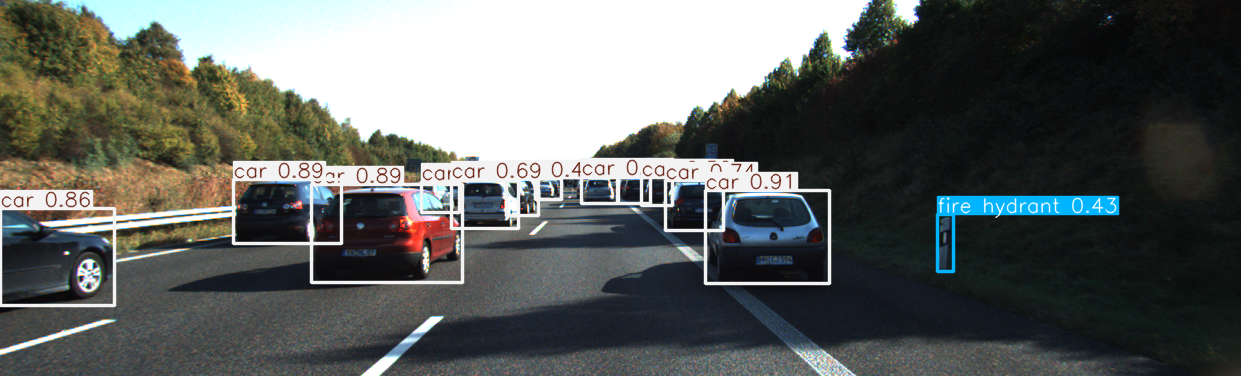

<ipython-input-15-2ce73158b368>:24: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  bboxes_out[:, :bboxes.shape[1]] = bboxes


In [19]:
import cv2
index = 10

left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
bin_path = bin_paths[index]
oxts_frame = get_oxts(oxts_paths[index])

# get detections and object centers in uvz
bboxes, velo_uvz = get_detection_coordinates(left_image, bin_path)

# get transformed coordinates of object centers
uvz = bboxes[:, -3:]

# transform to (u,v,z)
# velo_xyz = transform_uvz(uvz, T_cam2_velo) # we can also get LiDAR coordiantes
imu_xyz = transform_uvz(uvz, T_cam2_imu)

# get Lat/Lon on each detected object
lat0 = oxts_frame[0]
lon0 = oxts_frame[1]
alt0 = oxts_frame[2]
heading0 = oxts_frame[5]

lla = imu2geodetic(imu_xyz[:, 0], imu_xyz[:, 1], imu_xyz[:, 2], lat0, lon0, alt0, heading0)

In [20]:
velo_image = draw_velo_on_image(velo_uvz, np.zeros_like(left_image))

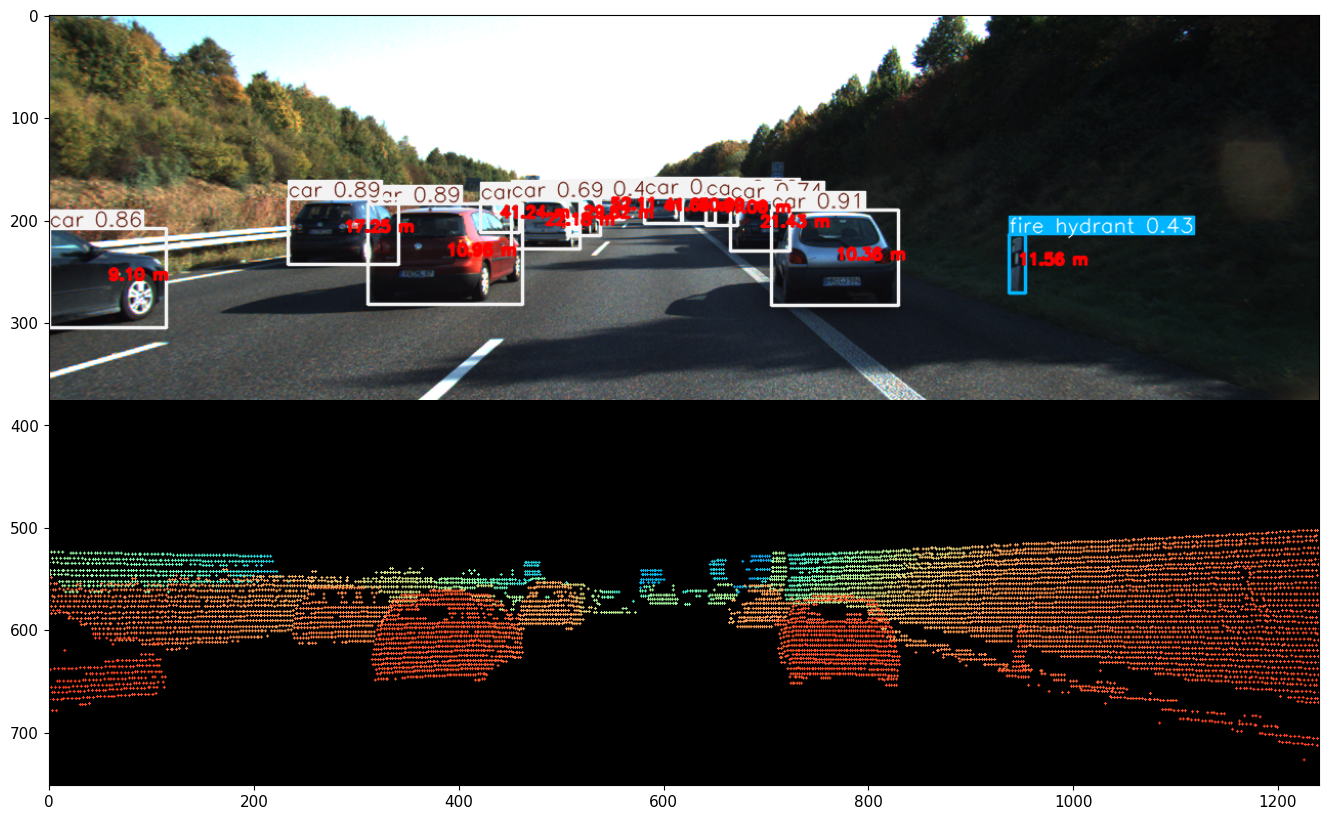

In [21]:
# pymap3d seems to mess with matplotlib in colab
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

# stack image with LiDAR point cloud
stacked = np.vstack((left_image, velo_image))

# display stacked iamge
plt.imshow(stacked);

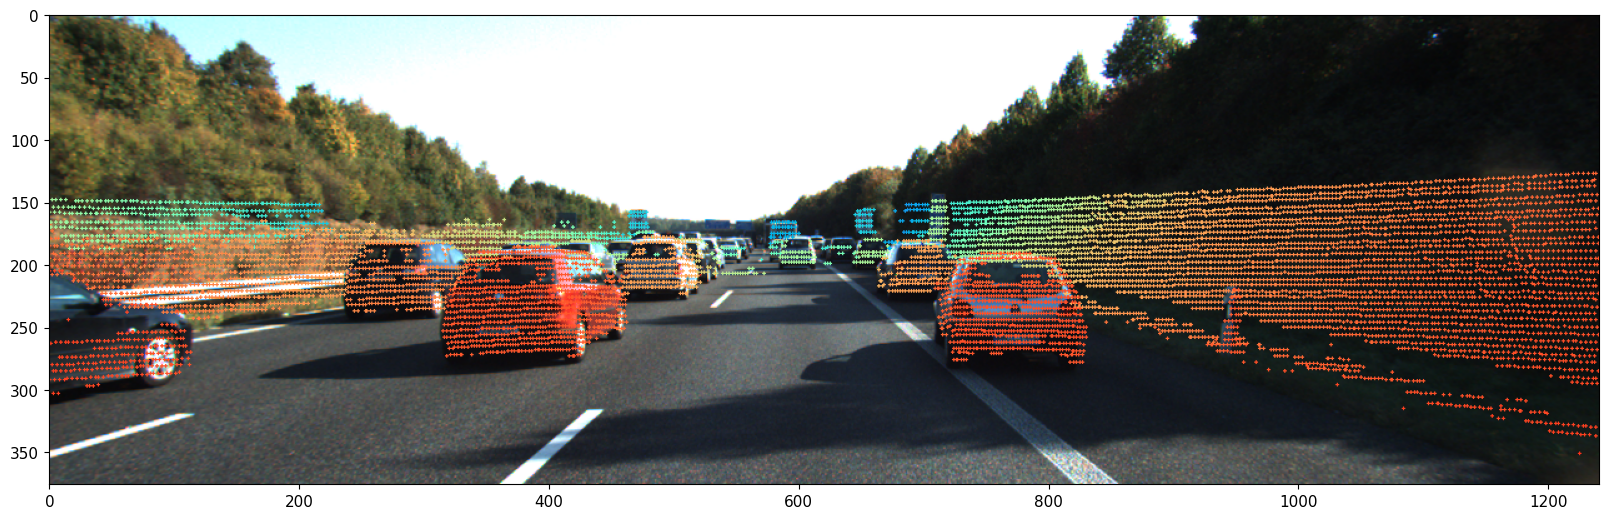

In [22]:
left_image_2 = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
velo_image_2 = draw_velo_on_image(velo_uvz, left_image_2)

plt.imshow(velo_image_2);

In [23]:
imu_xyz

array([[     11.446,     -2.4976,    -0.11944],
       [     18.329,      7.4931,    -0.10848],
       [     12.042,       3.171,    -0.15168],
       [     10.179,      6.7471,    -0.27394],
       [     22.516,     -2.7816,   -0.097632],
       [     23.267,      3.5915,    -0.11063],
       [     42.149,     -2.9994,    0.094871],
       [      42.73,     0.25856,    0.035392],
       [     30.901,      3.4319,   -0.079718],
       [     12.655,     -5.6226,    -0.29658],
       [     42.319,      9.3668,    -0.33184],
       [     53.193,      4.1462,    0.099585],
       [     52.078,      -2.119,    -0.14531]])

In [24]:
uvz

array([[     767.15,      239.49,      10.357],
       [     287.25,      211.88,       17.25],
       [     386.57,      235.75,      10.959],
       [     58.848,      255.17,      9.1014],
       [     694.49,      207.35,      21.425],
       [     485.02,       205.4,      22.184],
       [        657,      190.25,      41.056],
       [     600.06,      190.73,       41.64],
       [     520.37,      197.81,      29.817],
       [     944.73,      245.45,      11.564],
       [     441.19,      196.18,      41.244],
       [     548.04,      187.04,      52.107],
       [     635.03,      191.27,      50.987]])

In [25]:
(uvz[:, 2] + 1.08) - imu_xyz[:, 0]

array([ -0.0095994,   0.0013328,  -0.0028969,   0.0023714,   -0.010605,  -0.0032876,   -0.013486,  -0.0092651,  -0.0040865,   -0.011558,   0.0044812,  -0.0059038,   -0.010697])

In [26]:
!pip install folium

In [27]:
import folium

drive_map = folium.Map(
    location=(lat0, lon0), # starting location
    zoom_start=18
)

# add Lat/Lon points to map
folium.CircleMarker(location=(lat0, lon0),
                    radius=2,
                    weight=5,
                    color='red').add_to(drive_map);

In [28]:
# place the position of each detection on the map
for pos in lla:
    folium.CircleMarker(location=(pos[0], pos[1]),
                        radius=2,
                        weight=5,
                        color='green').add_to(drive_map);

# add Lat/Lon points to map
folium.CircleMarker(location=(lat0, lon0),
                    radius=2,
                    weight=5,
                    color='red').add_to(drive_map);

In [29]:
drive_map

In [30]:
canvas_height = stacked.shape[0]
canvas_width = 500

# get consistent center for ego vehicle
ego_center = (250, int(canvas_height*0.95))

# get rectangle coordiantes for ego vehicle
ego_x1 = ego_center[0] - 5
ego_y1 = ego_center[1] - 10
ego_x2 = ego_center[0] + 5
ego_y2 = ego_center[1] + 10

def draw_scenario(canvas, imu_xyz, sf=12):
    # draw ego vehicle
    cv2.rectangle(canvas, (ego_x1, ego_y1), (ego_x2, ego_y2), (0, 255, 0), -1);

    # draw detected objects
    for val in imu_xyz:
        obj_center = (ego_center[0] - sf*int(np.round(val[1])),
                      ego_center[1] - sf*int(np.round(val[0])))
        # cv2.circle(canvas, obj_center, 5, (255, 0, 0), -1);

        # get object rectangle coordinates
        obj_x1 = obj_center[0] - 5
        obj_y1 = obj_center[1] - 10
        obj_x2 = obj_center[0] + 5
        obj_y2 = obj_center[1] + 10

        cv2.rectangle(canvas, (obj_x1, obj_y1), (obj_x2, obj_y2), (255, 0, 0), -1);


    return canvas

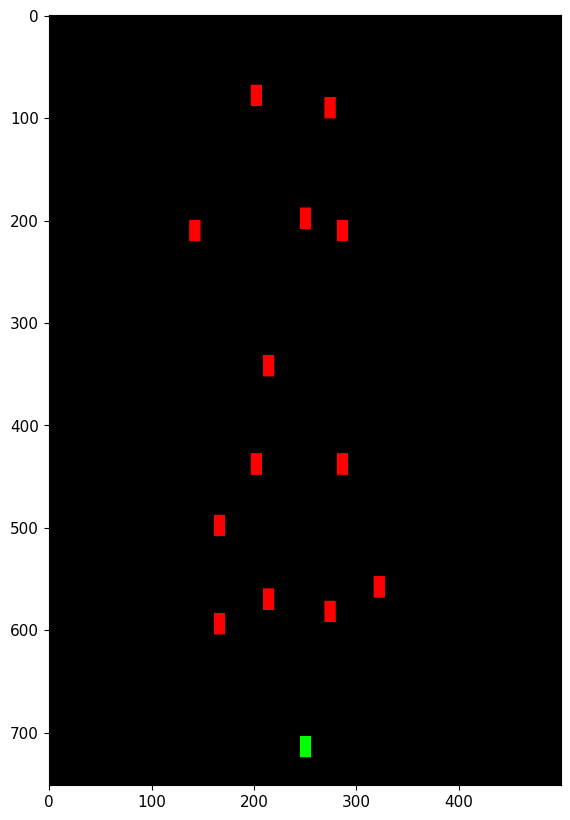

In [31]:
canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)
draw_scenario(canvas, imu_xyz, sf=12)
plt.imshow(canvas);

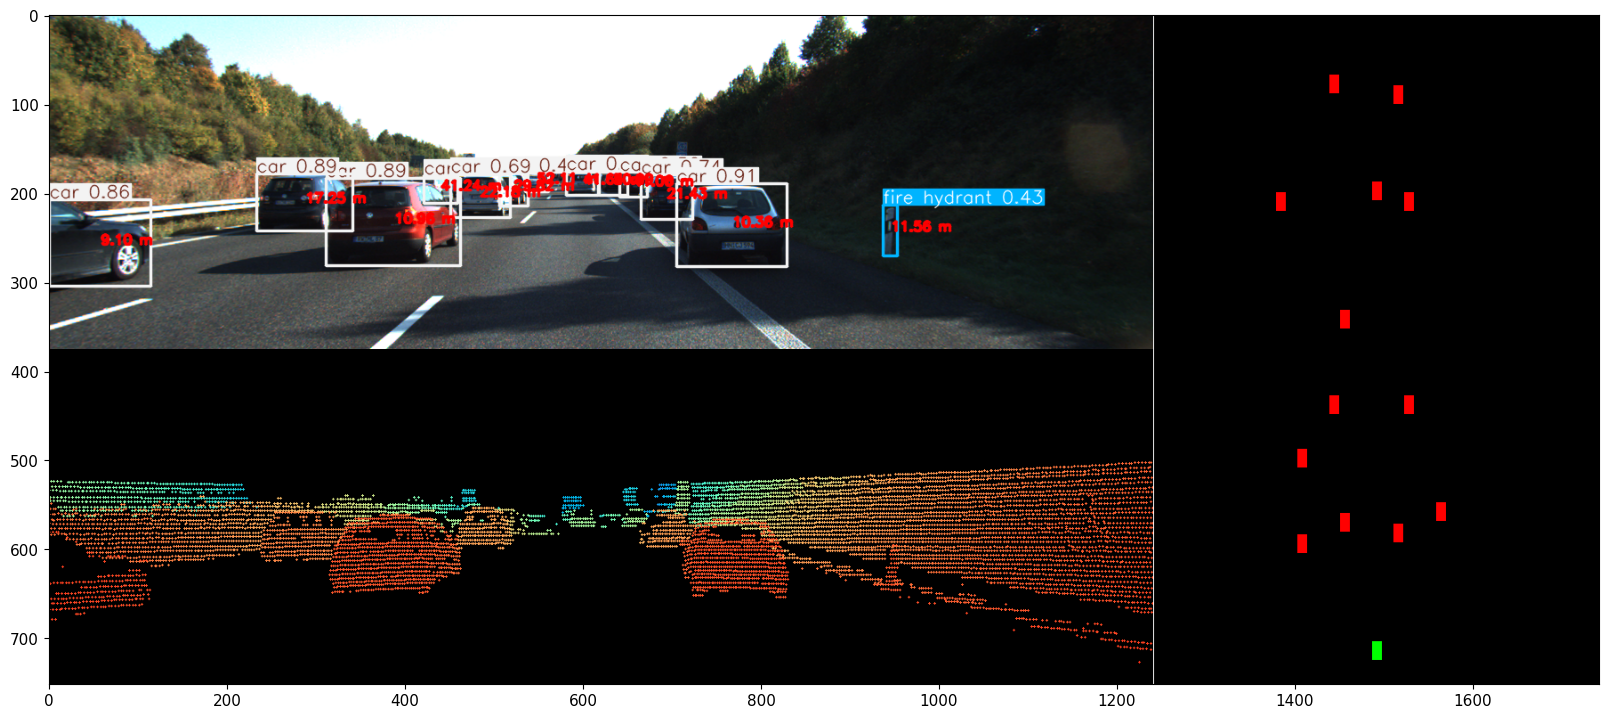

In [32]:
frame = np.hstack((stacked,
                  255*np.ones((canvas_height, 1, 3), dtype=np.uint8),
                  canvas))

plt.imshow(frame);

In [44]:
def timestamps2seconds(timestamp_path):
    ''' Reads in timestamp path and returns total seconds (does not account for day rollover '''
    # Remove squeeze=True from the call to pd.read_csv
    timestamps = pd.read_csv(timestamp_path,
                             header=None).astype(object)

    # If you want to squeeze the result into a Series if it has only one column,
    # you can do this after reading the data:
    if timestamps.shape[1] == 1:
        timestamps = timestamps.iloc[:, 0]

    # Apply split to each element of the Series, not the Series itself
    timestamps = timestamps.apply(lambda x: x.split(' ')[1] if isinstance(x, str) else x)

    # Get Hours, Minutes, and Seconds
    hours = timestamps.apply(lambda x: x.split(':')[0]).astype(np.float64)
    minutes = timestamps.apply(lambda x: x.split(':')[1]).astype(np.float64)
    seconds = timestamps.apply(lambda x: x.split(':')[2]).astype(np.float64)

    hms_vals = np.vstack((hours, minutes, seconds)).T

    total_seconds = np.array(list(map(get_total_seconds, hms_vals)))

    return total_seconds

In [45]:
cam2_total_seconds = timestamps2seconds(os.path.join(DATA_PATH, r'image_02/timestamps.txt'))

In [46]:
# camera 2 frames per second
cam2_fps = 1/np.median(np.diff(cam2_total_seconds))
cam2_fps

np.float64(9.650971459539951)

In [ ]:
result_video = []

for index in range(len(left_image_paths)):
    left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
    bin_path = bin_paths[index]
    oxts_frame = get_oxts(oxts_paths[index])

    # get detections and object centers in uvz
    bboxes, velo_uvz = get_detection_coordinates(left_image, bin_path)

    # get transformed coordinates
    uvz = bboxes[:, -3:]

    # velo_xyz = transform_uvz(uvz, T_cam2_velo) # we can also get LiDAR coordiantes
    imu_xyz = transform_uvz(uvz, T_cam2_imu)

    # draw velo on blank image
    velo_image = draw_velo_on_image(velo_uvz, np.zeros_like(left_image))

    # stack frames
    stacked = np.vstack((left_image, velo_image))

    # draw top down scenario on canvas
    canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)
    draw_scenario(canvas, imu_xyz, sf=12)

    # place everything in a single frame
    frame = np.hstack((stacked,
                       255*np.ones((canvas_height, 1, 3), dtype=np.uint8),
                       canvas))

    # add to result video
    result_video.append(frame)

# get width and height for video frames
h, w, _ = frame.shape

In [ ]:
out = cv2.VideoWriter('lidar_frame_stack.avi',
                      cv2.VideoWriter_fourcc(*'DIVX'),
                      cam2_fps,
                      (w,h))

for i in range(len(result_video)):
    out.write(cv2.cvtColor(result_video[i], cv2.COLOR_BGR2RGB))
out.release()

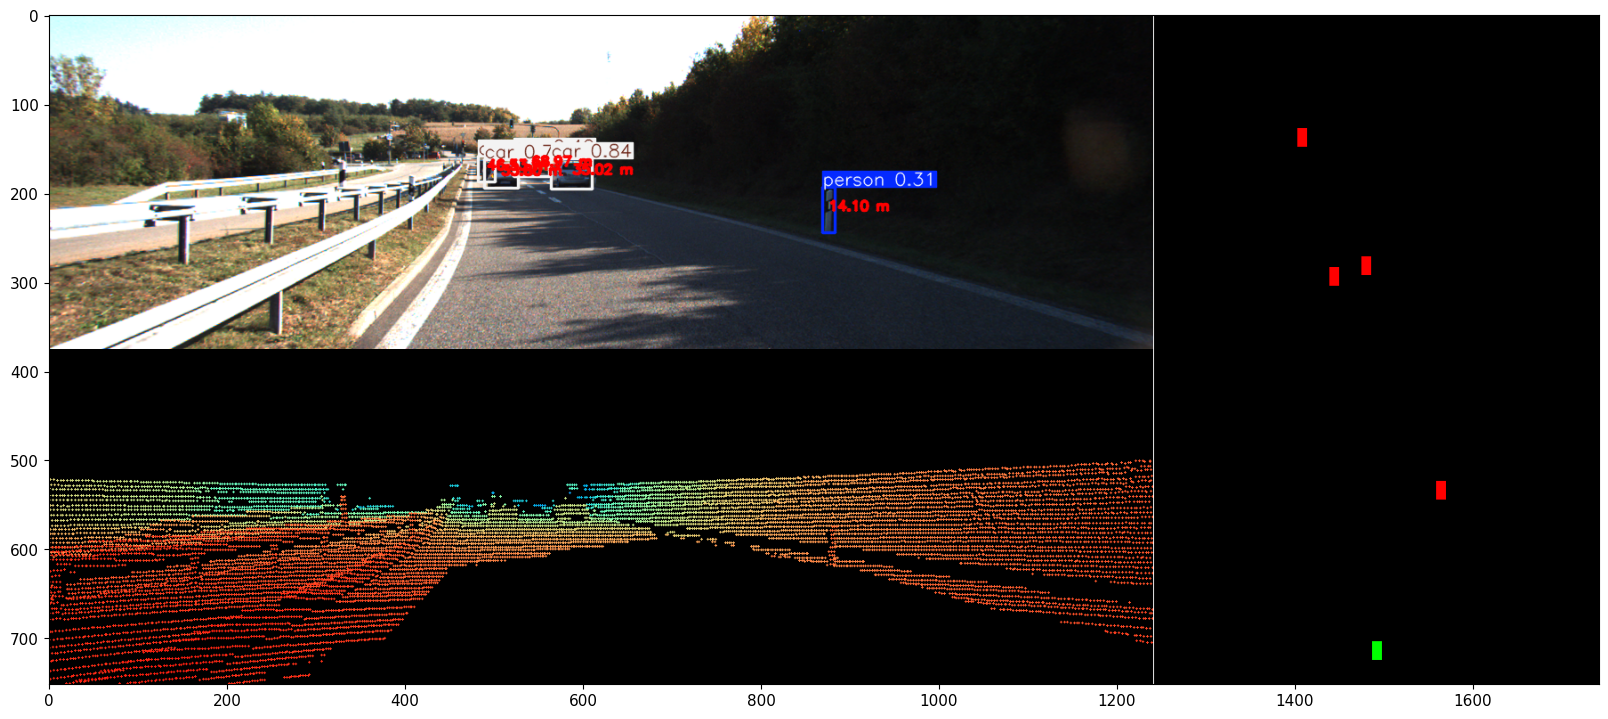

In [50]:
plt.imshow(frame);

In [56]:
import numpy as np
import cv2

def detect_collision(imu_xyz, speed_threshold=5.0, distance_threshold=10.0):
    """
    Detects potential collisions based on object distance and speed.
    Triggers alerts if an object is within a critical distance.
    """
    for obj in imu_xyz:
        distance = np.linalg.norm(obj[:2])  # Compute distance in 2D (x, y)
        if distance < distance_threshold:
            print("Warning: Object too close!")
            trigger_alert()
            if distance < distance_threshold / 2:
                trigger_braking()
            else:
                trigger_corrective_measures()

def trigger_alert():
    """ Simulates a visual and audio warning for potential collision """
    print("⚠️ Collision Warning! Slow Down!")

def trigger_braking():
    """ Simulates emergency braking mechanism """
    print("🚨 Emergency Braking Activated!")

def trigger_corrective_measures():
    """ Simulates corrective actions such as lane change or turn assist """
    print("🔄 Corrective action triggered: Adjusting lane or turning to avoid collision.")

def efficiency_improvements(model):
    """
    Optimizes object detection by adjusting confidence thresholds
    and using batch inference for faster processing.
    """
    model.conf = 0.3  # Adjust confidence threshold to reduce false positives
    model.iou = 0.4   # Improve intersection-over-union filtering
    print("✅ Efficiency improvements applied: Confidence adjusted, optimized processing.")

# Example usage:
# Assuming imu_xyz contains detected object coordinates
imu_xyz_sample = np.array([[3, 4, 0], [8, 2, 0], [1, 1, 0]])  # Example detected objects

detect_collision(imu_xyz_sample)

# Apply efficiency improvements to YOLO model
# efficiency_improvements(model)

⚠️ Collision Warning! Slow Down!
🔄 Corrective action triggered: Adjusting lane or turning to avoid collision.
⚠️ Collision Warning! Slow Down!
🔄 Corrective action triggered: Adjusting lane or turning to avoid collision.
⚠️ Collision Warning! Slow Down!
🚨 Emergency Braking Activated!
